# URAU city loop template

In [1]:
%matplotlib inline

import numpy as np
from shapely.geometry import MultiLineString, MultiPolygon, Polygon, box, shape
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import rasterio as rio
import IPython.display

# load utils functions
from f02_cube_utils import *

# Sentinel Hub
from sentinelhub import (
    CRS,
    BBox,
    BBoxSplitter,
    ByocCollection,
    ByocCollectionAdditionalData,
    ByocCollectionBand,
    ByocTile,
    DataCollection,
    DownloadFailedException,
    SentinelHubDownloadClient,
    MimeType,
    SentinelHubBYOC,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
    os_utils,
)

config = SHConfig()
config.instance_id = os.environ.get("SH_INSTANCE_ID")
config.sh_client_id = os.environ.get("SH_CLIENT_ID")
config.sh_client_secret = os.environ.get("SH_CLIENT_SECRET")
config.aws_access_key_id = os.environ.get("username")
config.aws_secret_access_key = os.environ.get("password")

## Import city bounding boxes
Load the bounding boxes of cities. The bounding box is passed as argument to `SentinelHubRequest`.
If the bounding box size (width, height) is too large (more than 2500), then we split the bounding box into smaller boxes and request them separately.

Uncomment and edit lines 3 and 4 to work with a selection of cities (useful for debugging).

Uncomment lines 7-19 to print the list of cities with bounding box size or number of subgrids.

Uncomment line 21 to plot a bounding box on the map.

In [2]:
c_bb = pd.read_csv("./../../../s3/data/d000_lookuptables/URAU_city_bboxes_4326.csv")
## select a subset of cities
cities_list = ["Verona"]
c_bb_subset = c_bb[c_bb['URAU_NAME'].isin(cities_list)]
resolution = 10
## print bbox sizes 
# for row in c_bb.itertuples():
#     print(row.URAU_NAME)
#     bbox_coords = row.minx, row.miny, row.maxx, row.maxy
#     bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84)
#     bbox_size = bbox_to_dimensions(bbox, resolution=resolution)
#     subsize = bbox_optimal_subsize(bbox_size)
#     if(subsize > 1):
#         bbox_split = BBoxSplitter([bbox], CRS.WGS84, subsize)
#         bbox_list = bbox_split.get_bbox_list()
#         print("Splitting bounding box in", (subsize,subsize), " subgrid")
#     else:
#         print(f"Image shape at {resolution} m resolution: {bbox_size} pixels")
#     print("-----------------")
## plot bounding box
# IPython.display.GeoJSON(shapely.geometry.box(*bbox_list[3]).__geo_interface__)

## Collections

In [3]:
# URAU Cities
collection_id_city = "20774d38-7b2e-43e9-b574-66fa2954da1c"
collection_name_city = "urban_audit_2021_city"
data_collection_city = DataCollection.define_byoc(collection_id_city, name=collection_name_city)
# Urban atlas
collection_id_UA = "27c95f8f-fb6b-46f2-8f84-2ce7761eeccd"
collection_name_UA = "UrbanAtlas2018_10m_raster_2"
data_collection_UA = DataCollection.define_byoc(collection_id_UA, name=collection_name_UA)

## Prepare request
Define evalscript and an helper function to get the SentinelHub requests

In [4]:
evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [
            {
                datasource: "city",
                bands: ["B1"]
            },
            {
                datasource: "UA",
                bands: ["B1"]
            }],
            output: {
                bands: 2,
                sampleType: "UINT16" // raster format will be UINT16
            }
        };
    }

    function evaluatePixel(samples, inputData, inputMetadata, customData, outputMetadata) {
        var sample_city = samples.city[0]
        var sample_ua = samples.UA[0]
        return [sample_city.B1, sample_ua.B1];

      
    }
"""
input_data = [
        SentinelHubRequest.input_data(
            data_collection=DataCollection.urban_audit_2021_city,
            identifier="city",
        ),
        SentinelHubRequest.input_data(
            data_collection=DataCollection.UrbanAtlas2018_10m_raster_2,
            identifier="UA",
        )
    ]
def sentinelhub_request(evalscript,input_data, bbox, size, config, data_folder):
    return SentinelHubRequest(
        evalscript=evalscript,
        input_data=input_data,
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=size,
        config=config,
        data_folder=data_folder
    )

Helper function to decide whether the bounding box needs to be further splitted

## Main loop 1 - data download

In [36]:
# data_folder = "./../../../s3/data/c001_city_cube/"
# cached_names = []
# for row in c_bb_subset.itertuples():
#     print("Downloading " + row.URAU_NAME + " data")
#     bbox_coords = row.minx, row.miny, row.maxx, row.maxy
#     bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84)
#     bbox_size = bbox_to_dimensions(bbox, resolution=10)
#     bbox_subsize = bbox_optimal_subsize(bbox_size)
#     if(bbox_subsize == 1 ):
#         request = sentinelhub_request(evalscript,input_data, bbox, bbox_size, config, data_folder)
#         # download data
#         dl_request = request.download_list[0]
#         downloaded_data = SentinelHubDownloadClient(config=config).download(dl_request, max_threads=5)
#         # save filename
#         cached_names.append([row.URAU_CODE, row.URAU_NAME, Path(data_folder) / request.get_filename_list()[0], bbox])
#     else:
#         print("Splitting bounding box in", (bbox_subsize,bbox_subsize), " subgrid")
#         bbox_split = BBoxSplitter([bbox], CRS.WGS84, bbox_subsize)
#         # create a list of requests
#         bbox_list = bbox_split.get_bbox_list()
#         sh_requests = [sentinelhub_request(evalscript,input_data, subbbox, bbox_to_dimensions(subbbox, resolution=resolution), config, data_folder) for subbbox in bbox_list]
#         dl_requests = [request.download_list[0] for request in sh_requests]
#         # download data with multiple threads
#         downloaded_data = SentinelHubDownloadClient(config=config).download(dl_requests, max_threads=5)
#         for req,subbbox in zip(sh_requests,bbox_list):
#             cached_names.append([row.URAU_CODE, row.URAU_NAME, Path(data_folder) / req.get_filename_list()[0], subbbox])
#     print("---------------------------")
        

Splitting bounding box in (2, 2)  subgrid
---------------------------


### Save paths to data in lookup table

SentinelHub assigns a cache code to downloaded data, which is also used as filename. At the next download request, it checks the cache code to avoid downloading the data twice.
In order to retrieve the right files for further processing, we create a lookup table joining the city code and the cache code.

In [ ]:
cn = pd.DataFrame(cached_names, columns = ["URAU_CODE", "URAU_NAME", "path", "bbox"])
cn
# cn.to_csv(lookuptable_folder+"city_UA_subcubes_path.csv", index=False)

,URAU_CODE,URAU_NAME,path,bbox
0,NO001C,Oslo,../../../s3/data/c001_city_cube/2c55798d9ed9d8...,"10.4892,59.8093,10.7203,59.9722"
1,NO001C,Oslo,../../../s3/data/c001_city_cube/8ac06c0286b2c9...,"10.4892,59.9722,10.7203,60.1351"
2,NO001C,Oslo,../../../s3/data/c001_city_cube/d42fc4be6f10ba...,"10.7203,59.8093,10.9514,59.9722"
3,NO001C,Oslo,../../../s3/data/c001_city_cube/bf3678f8e93c73...,"10.7203,59.9722,10.9514,60.1351"


## Main loop 2 - process subcubes on the fly
`request.get_data()` either loads data from SentinelHub or, if it was already downloaded, from `data_folder`.

In [5]:
data_folder = "./../../../s3/data/c001_city_cube/"
for row in c_bb_subset.itertuples():
    print("Downloading " + row.URAU_NAME + " data")
    bbox_coords = row.minx, row.miny, row.maxx, row.maxy
    bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84)
    bbox_size = bbox_to_dimensions(bbox, resolution=10)
    bbox_subsize = bbox_optimal_subsize(bbox_size)
    if(bbox_subsize == 1 ):
        request = sentinelhub_request(evalscript,input_data, bbox, bbox_size, config, data_folder)
        data = request.get_data()[0]
        # do something with the data
        output_file = data_folder + "tables/" + row.URAU_NAME + ".csv"
        combine_ua_table_from_city_subcube(data, output_file, bbox, bbox_size)
    else:
        print("Splitting bounding box in", (bbox_subsize,bbox_subsize), " subgrid")
        bbox_split = BBoxSplitter([bbox], CRS.WGS84, bbox_subsize)
        # create a list of requests
        bbox_list = bbox_split.get_bbox_list()
        sh_requests = [sentinelhub_request(evalscript,input_data, subbbox, bbox_to_dimensions(subbbox, resolution=resolution), config, data_folder) for subbbox in bbox_list]
        i = 1
        for req,subbbox in zip(sh_requests,bbox_list):
            data = req.get_data()[0]
            # do something with the data
            output_file = data_folder + "tables/" + row.URAU_NAME + "_" + str(i) + ".csv"
            combine_ua_table_from_city_subcube(data, output_file, subbbox, bbox_to_dimensions(subbbox, resolution=resolution))
            i = i+1
    print("---------------------------")
        

---------------------------


## Visualization
As a test, we load a tiff from `data/c001_city_cubec001_city_cube` and plot it.

`get_tiff_paths_from_code` is an helper function to resolve the tiff path from the city code. It returns 

In [41]:
# load tiff files in memory
paths =  get_tiff_paths_from_code("NO001C")
paths

0    ../../../s3/data/c001_city_cube/2c55798d9ed9d8...
1    ../../../s3/data/c001_city_cube/8ac06c0286b2c9...
2    ../../../s3/data/c001_city_cube/d42fc4be6f10ba...
3    ../../../s3/data/c001_city_cube/bf3678f8e93c73...
Name: path, dtype: object

In [44]:
# explore a subset of the data
import rasterio
src = rasterio.open(paths[0])
d_c = src.read(1)
d_c.shape

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(1845, 1249)

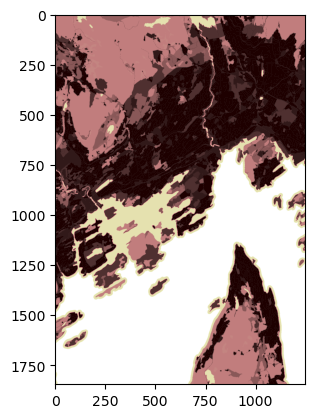

In [46]:
from matplotlib import pyplot
pyplot.imshow(src.read(2), cmap='pink')
pyplot.show()  